In [17]:
import MRzeroCore as mr0
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch
from torch.nn.functional import interpolate

(pulseq_pTx)=

In [18]:
# Create a phantom by merging BrainWeb and adj data
phantom = mr0.VoxelGridPhantom.brainweb("subject05.npz")
phantom = phantom.interpolate(64, 64, 32).slices([15])
mask = phantom.PD[:, :, 0] > 1e-3

# Extract necessary data from the MATLAB .mat file
file = scipy.io.loadmat("AdjDataUser2gB0_transversal_0.08moving_average.mat")["Adj"]
size = (file["image_m"][0, 0][0, 0], file["image_n"][0, 0][0, 0], file["slices"][0, 0][0, 0])
coil_count = file["coils"][0, 0][0, 0]
voxel_pos = np.stack(np.meshgrid(file["values_m"][0, 0], file["values_n"][0, 0], file["values_s"][0, 0]), -1)

# Crop and interpolate B0 data to roughly fit BrainWeb
B0 = torch.tensor(file["B0"][0, 0][:, :, size[2] // 2], dtype=torch.float)
B0 = B0[27:61, 20:54].flip(0).T
B0 = interpolate(
    B0[None, None, :, :], (64, 64), mode="area"
)[0, 0, :, :, None]

# Crop and interpolate B1 data to roughly fit BrainWeb
B1 = torch.tensor(file["S"][0, 0][:, :, size[2] // 2], dtype=torch.cfloat).T.reshape(-1, size[0], size[1])
B1 = B1[:, 27:61, 20:54].flip(2)
B1 = (
    interpolate(B1.real[:, None, :, :], (64, 64), mode="area")[:, 0, :, :, None]
    + 1j * interpolate(B1.imag[:, None, :, :], (64, 64), mode="area")[:, 0, :, :, None]
)

B0[~mask] = 0
B1[:, ~mask] = 0
B0 -= B0[mask].mean()

normalize = False
if normalize:
    # Remove phase from B1
    for i in range(coil_count):
        B1[i, ...] *= torch.exp(-1j * B1[i, mask].mean().angle())
    # Normalize B1 so that quadrature mode has a mean of abs = 1 and phase = 0
    B1 *= np.exp(-1j * B1.sum(0)[mask].mean().angle()) / B1.sum(0)[mask].mean().abs()

phantom.B0 = B0
phantom.B1 = B1

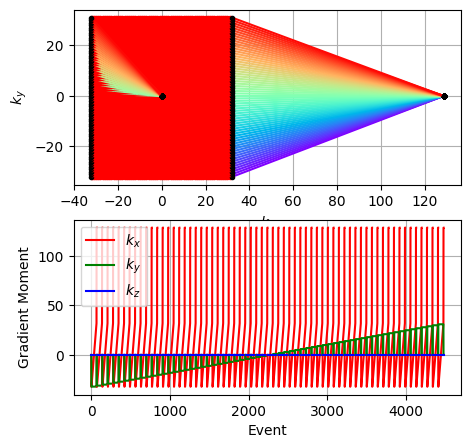

Calculating repetition 64 / 64 - done


In [19]:
data = phantom.build()

seq_file = mr0.PulseqFile("out/flash pTx EP.seq")
seq = mr0.Sequence.from_seq_file(seq_file)
seq.plot_kspace_trajectory()

# Create a non-pTx version of the sequence
prepass_seq = seq.clone()
for rep in prepass_seq:
    rep.pulse.angle = rep.pulse.angle.mean() / np.sqrt(1 / rep.pulse.angle.numel())
    rep.pulse.phase = rep.pulse.phase.mean()

# Simulate the sequence
graph = mr0.compute_graph(prepass_seq, data, 200, 1e-3)
signal = mr0.execute_graph(graph, seq, data)

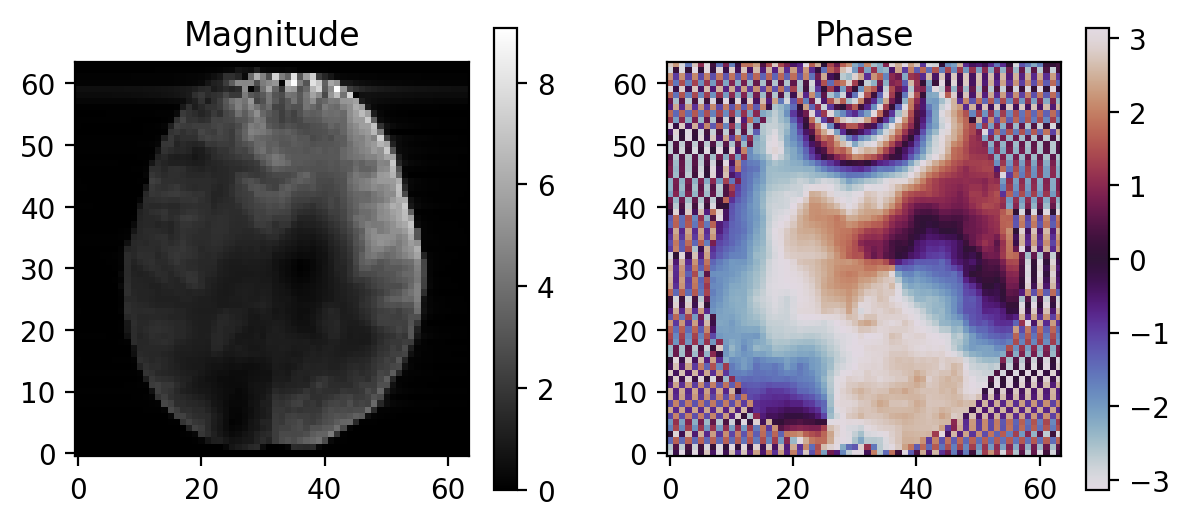

In [20]:
reco = mr0.reco_adjoint(signal, seq.get_kspace(), resolution=(64, 64, 1), FOV=(1, 1, 1))

plt.figure(figsize=(7, 3), dpi=200)
plt.subplot(121)
plt.title("Magnitude")
plt.imshow(reco[:, :, 0].T.abs(), origin="lower", vmin=0, cmap="gray")
plt.colorbar()
plt.subplot(122)
plt.title("Phase")
plt.imshow(reco[:, :, 0].T.angle(), origin="lower", vmin=-np.pi, vmax=np.pi, cmap="twilight")
plt.colorbar()
plt.show()